### Regresión Logística 
### 1. Importamos las librerías

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score,make_scorer, roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV


import warnings
warnings.filterwarnings("ignore")

### 2. Lectura de datos

In [2]:
# Devuelve el directorio de un nombre de ruta dado
ruta_base = os.getcwd() 
ruta_data = os.path.join(ruta_base, "..", "data", "loan_data.csv")
# Cargar el CSV
df_loan = pd.read_csv(ruta_data )

# Resolver el problema de outliers -------------------------------------------

# 1. Binarizar `pub.rec`: 0 = sin registros, 1 = con al menos uno
df_loan['pub.rec_flag'] = df_loan['pub.rec'].apply(lambda x: 1 if x > 0 else 0)

# 2. Agrupar `delinq.2yrs`: '0' vs '1 o más'
df_loan['delinq.2yrs_binned'] = df_loan['delinq.2yrs'].apply(lambda x: '0' if x == 0 else '1+')

# 3. Transformar `revol.bal` con logaritmo para reducir asimetría
df_loan['log.revol.bal'] = np.log1p(df_loan['revol.bal'])  # log(x + 1) evita log(0)

### 3. Preparación de datos para la regresión logística

In [3]:
# Se consideran variables que no impliquen una multicolinealidad
df_loan_RL = df_loan.drop(columns=['revol.bal','delinq.2yrs','pub.rec_flag'])

# Se cambia delinq.2yrs_binned por variable binaria
df_loan_RL['delinq.2yrs_binned'] = df_loan_RL['delinq.2yrs_binned'].map({'0':0,'1+':1})

# Identificar columnas numericas y columnas categoricas y binarias
variables_numericas = ['int.rate','installment','log.annual.inc','dti','fico','days.with.cr.line','revol.util','inq.last.6mths','pub.rec','log.revol.bal']
variables_categoricas = ['purpose']
variables_binarias = ['credit.policy', 'delinq.2yrs_binned','not.fully.paid']

# Separar en dos df's: X variables de entrada, Y variable de salida (not.fully.paid)
X = df_loan_RL.drop("not.fully.paid", axis=1)
y = df_loan_RL["not.fully.paid"]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=123)

### 4. Preprocesamiento y Pipeline

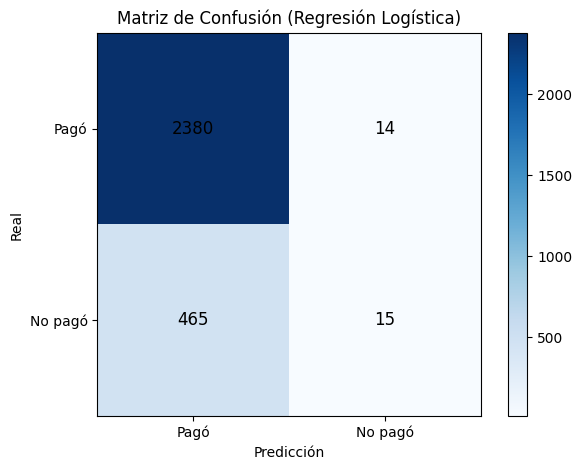


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.84      0.99      0.91      2394
           1       0.52      0.03      0.06       480

    accuracy                           0.83      2874
   macro avg       0.68      0.51      0.48      2874
weighted avg       0.78      0.83      0.77      2874



In [4]:
# Transformador de columnas categóricas en dummies con el onehot y estandariza las numericas.
preprocesar_datos = ColumnTransformer(
    transformers=[
        ('estandarizar',StandardScaler(),variables_numericas),
        ('onehot',OneHotEncoder(drop='first'),variables_categoricas)
    ],
    remainder='passthrough')

# Clasificador RL
regresion_log = LogisticRegression(max_iter=1000, random_state=123)

# Objeto Pipeline
pipeline = Pipeline([
    ("preprocesar", preprocesar_datos),
    ("clasificador", regresion_log)])

#Entrenamiento 
pipeline.fit(X_train, y_train)

#Predicciones
y_pred = pipeline.predict(X_test)

# Métricas
# Calcular la matriz de confusión
matriz = confusion_matrix(y_test, y_pred)
plt.imshow(matriz, cmap="Blues")
plt.title("Matriz de Confusión (Regresión Logística)")
plt.xlabel("Predicción")
plt.ylabel("Real")
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(matriz[i, j]), ha='center', va='center', fontsize=12, color='black')
plt.colorbar()
plt.xticks([0, 1], ["Pagó","No pagó"])
plt.yticks([0, 1], ["Pagó","No pagó"])
plt.tight_layout()
plt.show()

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

Mejores hiperparámetros: {'clasificador__C': np.float64(1.5)}

Mejor umbral: 0.20
Mejor F1-score (clase 1): 0.3448

Reporte de Clasificación (Regresión Logística):
              precision    recall  f1-score   support

           0       0.88      0.79      0.83      8045
           1       0.29      0.44      0.35      1533

    accuracy                           0.74      9578
   macro avg       0.58      0.62      0.59      9578
weighted avg       0.79      0.74      0.76      9578



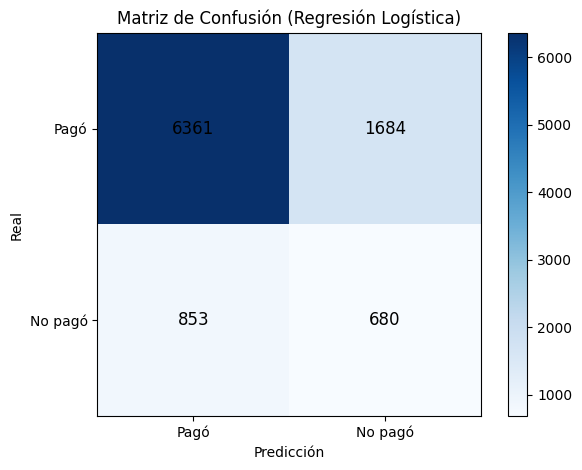

In [5]:
# GridSearchCV para buscar el mejor C
param_grid = {
    "clasificador__C": np.arange(1, 10, 0.5)
}

#  GridSearchCV con validación cruzada estratificada y F1-score clase 1
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
scorer = make_scorer(f1_score, pos_label=1)
grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring=scorer, n_jobs=-1)
grid.fit(X, y)
mejor_modelo = grid.best_estimator_
print("Mejores hiperparámetros:", grid.best_params_)

# Validación cruzada para obtener probabilidades utilizando modoelo previamente optimizado con gridsearchcv
umbrales = np.arange(0.10, 0.90, 0.05)
y_probabilidades = np.zeros_like(y, dtype=float)
y_reales = np.zeros_like(y)

for train_idx, test_idx in cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    mejor_modelo.fit(X_train, y_train)
    probas = mejor_modelo.predict_proba(X_test)[:, 1]
    y_probabilidades[test_idx] = probas
    y_reales[test_idx] = y_test

# Buscamos el mejor umbral que maximiza F1-score de la clase 1
f1_scores = []
for umbral in umbrales:
    y_pred = (y_probabilidades >= umbral).astype(int)
    f1_scores.append(f1_score(y_reales, y_pred, pos_label=1))

mejor_umbral = umbrales[np.argmax(f1_scores)]
print(f"\nMejor umbral: {mejor_umbral:.2f}")
print(f"Mejor F1-score (clase 1): {max(f1_scores):.4f}")

# Entrenamos modelo final con todos los datos disponibles y aplica el mejro umbral para convertir la probabilidad en 0 o 1
mejor_modelo.fit(X, y)
y_prob_final = mejor_modelo.predict_proba(X)[:, 1]
y_pred_final = (y_prob_final >= mejor_umbral).astype(int)

# Reporte final
print("\nReporte de Clasificación (Regresión Logística):")
print(classification_report(y, y_pred_final))

# Calcular la matriz de confusión
matriz = confusion_matrix(y, y_pred_final)
plt.imshow(matriz, cmap="Blues")
plt.title("Matriz de Confusión (Regresión Logística)")
plt.xlabel("Predicción")
plt.ylabel("Real")
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(matriz[i, j]), ha='center', va='center', fontsize=12, color='black')
plt.colorbar()
plt.xticks([0, 1], ["Pagó","No pagó"])
plt.yticks([0, 1], ["Pagó","No pagó"])
plt.tight_layout()
plt.show()


In [6]:
# coeficientes
modelo_rl = pipeline.named_steps['clasificador']
coeficientes = modelo_rl.coef_[0]  # Vector de coeficientes (para clase 1)
# Accede al preprocesador
preprocesador = pipeline.named_steps['preprocesar']

# Obtener nombres de variables categóricas después de one-hot encoding
onehot = preprocesador.named_transformers_['onehot']
cat_vars = onehot.get_feature_names_out(variables_categoricas)

# Variables pasadas sin transformar (remainder='passthrough')
remainder_vars = [col for col in X.columns if col not in variables_numericas+variables_categoricas]

# Combinar todos los nombres de columnas transformadas
nombres_variables = list(variables_numericas) + list(cat_vars) + list(remainder_vars)
for nombre, coef in zip(nombres_variables, coeficientes):
    print(f"{nombre}: {coef:.4f}")

int.rate: -0.0093
installment: 0.2900
log.annual.inc: -0.2498
dti: -0.0005
fico: -0.3364
days.with.cr.line: 0.0618
revol.util: 0.1302
inq.last.6mths: 0.1909
pub.rec: 0.0469
log.revol.bal: -0.0262
purpose_credit_card: -0.5080
purpose_debt_consolidation: -0.3101
purpose_educational: 0.1541
purpose_home_improvement: 0.0495
purpose_major_purchase: -0.4076
purpose_small_business: 0.5051
credit.policy: -0.4451
delinq.2yrs_binned: -0.1037
